# 1 

In [12]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add current directory to path to find 'core' and 'utils'
sys.path.append(os.getcwd())

from Core.models import Sequential
from Core.layers import RoughRBFLayer, RoughDenseLayer
from Core.losses import MSELoss
from Core.optimizers import SGD, CompetitiveLearning
from Utils.data_utils import DataHandler

# Visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported and environment set up.")

Libraries imported and environment set up.


# 2

In [13]:
def build_rough_rbf_network(input_dim, num_kernels, output_dim=1):
    """
    Creates a Rough RBF Network structure:
    Input -> RoughRBFLayer -> RoughDenseLayer -> Output
    """
    model = Sequential()
    # Layer 1: Rough RBF (Gaussian Kernels with Interval Parameters)
    model.add(RoughRBFLayer(input_dim=input_dim, num_kernels=num_kernels))
    # Layer 2: Rough Dense (Interval Weights)
    model.add(RoughDenseLayer(input_dim=num_kernels, output_dim=output_dim))
    return model

def plot_rough_predictions(model, X, y_true, title="Rough RBF Prediction", sample_range=None):
    """
    Runs prediction and plots True vs Predicted (Crisp) 
    along with the Lower and Upper bounds (Rough Interval).
    """
    # 1. Get Crisp Predictions
    y_pred_crisp = model.predict(X).flatten()
    y_true = y_true.flatten()
    
    # 2. Extract Lower and Upper bounds manually
    # Since model.predict returns the crisp value, we iterate to get internal states
    y_L_list = []
    y_U_list = []
    
    # Access the last layer (RoughDenseLayer) to get L/U bounds
    output_layer = model.layers[-1]
    
    for i in range(len(X)):
        model.forward(X[i]) # Run forward to update layer states
        y_L_list.append(output_layer.net_L.item())
        y_U_list.append(output_layer.net_U.item())
        
    y_L = np.array(y_L_list)
    y_U = np.array(y_U_list)
    
    # Optional: Zoom in on a specific range
    if sample_range:
        start, end = sample_range
        indices = range(start, end)
    else:
        indices = range(len(y_true))
        
    # 3. Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(indices, y_true[indices], color='black', label='Actual Data', linewidth=2)
    plt.plot(indices, y_pred_crisp[indices], color='red', linestyle='--', label='Crisp Prediction')
    
    # Fill the Rough Interval (Uncertainty)
    plt.fill_between(indices, y_L[indices], y_U[indices], color='red', alpha=0.2, label='Rough Interval [L, U]')
    
    plt.title(title)
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

# 3

In [14]:
# Paths to datasets (Adjust if your folder structure is different)
LORENZ_PATH = '../HW2/Datasets/regression/Lorenz Dataset.xlsx'
TEMP_PATH = '../HW2/Datasets/regression/Temperature Dataset.xlsx'

# 1. Load Data
print("Loading Datasets...")
lorenz_raw = DataHandler.load_data(LORENZ_PATH)
temp_raw = DataHandler.load_data(TEMP_PATH)

# 2. Normalize Data (Crucial for RBF performance)
lorenz_norm, scaler_l = DataHandler.normalize_data(lorenz_raw)
temp_norm, scaler_t = DataHandler.normalize_data(temp_raw)

# 3. Create Sequences
# Question requires: 5 input steps, predict the 3rd future step
INPUT_STEPS = 5
PRED_HORIZON = 3

X_lorenz, y_lorenz = DataHandler.create_sequences(lorenz_norm, input_steps=INPUT_STEPS, prediction_horizon=PRED_HORIZON)
X_temp, y_temp = DataHandler.create_sequences(temp_norm, input_steps=INPUT_STEPS, prediction_horizon=PRED_HORIZON)

# 4. Train/Test Split (No shuffling for Time Series)
X_train_l, X_test_l, y_train_l, y_test_l = DataHandler.train_test_split(X_lorenz, y_lorenz, train_ratio=0.7, shuffle=False)
X_train_t, X_test_t, y_train_t, y_test_t = DataHandler.train_test_split(X_temp, y_temp, train_ratio=0.7, shuffle=False)

print(f"Lorenz Data: Train={X_train_l.shape}, Test={X_test_l.shape}")
print(f"Temperature Data: Train={X_train_t.shape}, Test={X_test_t.shape}")

Loading Datasets...
Lorenz Data: Train=(1395, 5), Test=(598, 5)
Temperature Data: Train=(230, 5), Test=(99, 5)


# 4

Training on Lorenz Dataset...
Starting Training | Mode: SGD | Epochs: 100 | Samples: 1395
Validation enabled | Val Samples: 598


Epoch 1/100: 100%|██████████| 1395/1395 [00:01<00:00, 886.78sample/s, train_loss=0.00085]


Epoch 1 finished. Train Loss: 0.005951 | Val Loss: 0.015497


Epoch 10/100: 100%|██████████| 1395/1395 [00:01<00:00, 926.89sample/s, train_loss=0.00030]


Epoch 10 finished. Train Loss: 0.000888 | Val Loss: 0.002198


Epoch 20/100: 100%|██████████| 1395/1395 [00:01<00:00, 908.36sample/s, train_loss=0.00014]


Epoch 20 finished. Train Loss: 0.000600 | Val Loss: 0.001267


Epoch 30/100: 100%|██████████| 1395/1395 [00:01<00:00, 728.51sample/s, train_loss=0.00004]


Epoch 30 finished. Train Loss: 0.000421 | Val Loss: 0.000715


Epoch 40/100: 100%|██████████| 1395/1395 [00:02<00:00, 645.93sample/s, train_loss=0.00001]


Epoch 40 finished. Train Loss: 0.000314 | Val Loss: 0.000432


Epoch 50/100: 100%|██████████| 1395/1395 [00:02<00:00, 685.64sample/s, train_loss=0.00000]


Epoch 50 finished. Train Loss: 0.000251 | Val Loss: 0.000302


Epoch 60/100: 100%|██████████| 1395/1395 [00:02<00:00, 661.87sample/s, train_loss=0.00001]


Epoch 60 finished. Train Loss: 0.000214 | Val Loss: 0.000247


Epoch 70/100: 100%|██████████| 1395/1395 [00:02<00:00, 672.67sample/s, train_loss=0.00001]


Epoch 70 finished. Train Loss: 0.000190 | Val Loss: 0.000225


Epoch 80/100: 100%|██████████| 1395/1395 [00:01<00:00, 720.51sample/s, train_loss=0.00002]


Epoch 80 finished. Train Loss: 0.000173 | Val Loss: 0.000215


Epoch 90/100: 100%|██████████| 1395/1395 [00:02<00:00, 692.14sample/s, train_loss=0.00003]


Epoch 90 finished. Train Loss: 0.000161 | Val Loss: 0.000209


Epoch 100/100: 100%|██████████| 1395/1395 [00:02<00:00, 693.22sample/s, train_loss=0.00003]


Epoch 100 finished. Train Loss: 0.000151 | Val Loss: 0.000203
Training Complete. Time: 44.52s


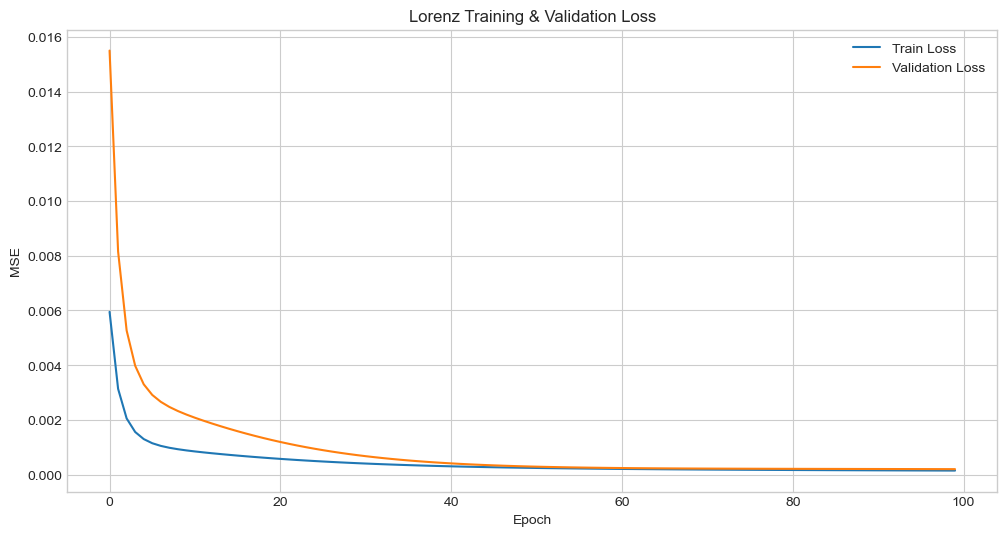

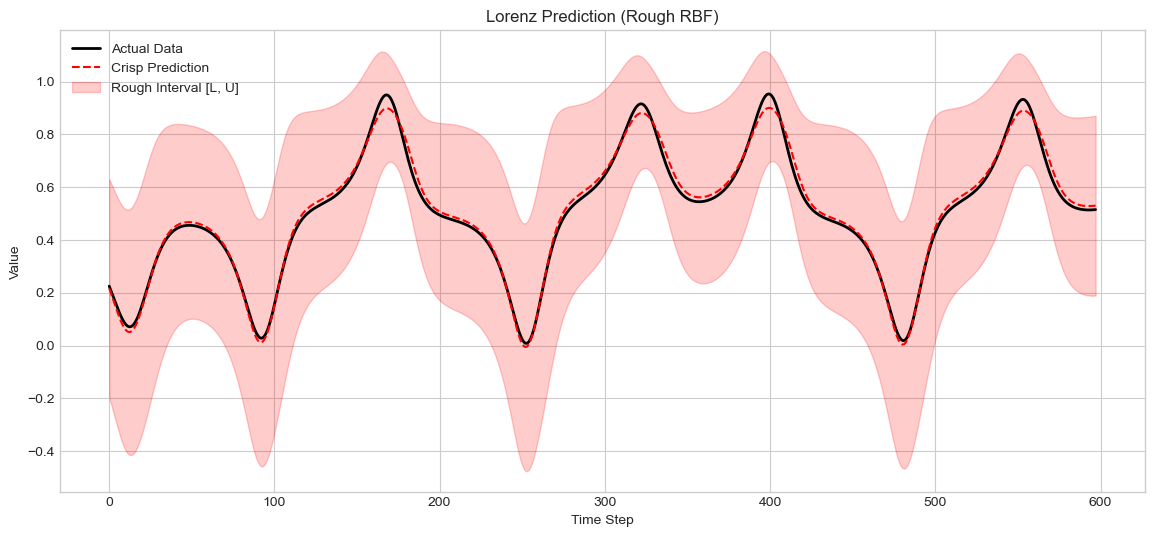

In [15]:
# --- Lorenz Training ---

# 1. Build Model
# Input dim = 5, using 20 Kernels for complex chaotic dynamics
model_lorenz = build_rough_rbf_network(input_dim=5, num_kernels=20)

# 2. Compile
# Learning rates: Base=0.05, Centers=0.01, Sigmas=0.01
optimizer = SGD(lr=0.05, lr_centers=0.01, lr_sigmas=0.01)
loss_fn = MSELoss()

model_lorenz.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
# Passing validation_data to monitor overfitting
print("Training on Lorenz Dataset...")
history_l = model_lorenz.fit(X_train_l, y_train_l, 
                             validation_data=(X_test_l, y_test_l), 
                             epochs=100, verbose=True, log_freq= 10)

# 4. Plot Loss
plt.figure()
plt.plot(history_l['loss'], label='Train Loss')
plt.plot(history_l['val_loss'], label='Validation Loss')
plt.title("Lorenz Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 5. Visualize Predictions (Zoom in on first 100 test samples)
plot_rough_predictions(model_lorenz, X_test_l, y_test_l, 
                       title="Lorenz Prediction (Rough RBF)")

# 5

Training on Temperature Dataset...
Starting Training | Mode: SGD | Epochs: 100 | Samples: 230
Validation enabled | Val Samples: 99


Epoch 1/100: 100%|██████████| 230/230 [00:00<00:00, 690.59sample/s, train_loss=0.02361]


Epoch 1 finished. Train Loss: 0.021154 | Val Loss: 0.088235


Epoch 10/100: 100%|██████████| 230/230 [00:00<00:00, 712.08sample/s, train_loss=0.02360]


Epoch 10 finished. Train Loss: 0.010993 | Val Loss: 0.025874


Epoch 20/100: 100%|██████████| 230/230 [00:00<00:00, 675.53sample/s, train_loss=0.02208]


Epoch 20 finished. Train Loss: 0.007365 | Val Loss: 0.011761


Epoch 30/100: 100%|██████████| 230/230 [00:00<00:00, 807.55sample/s, train_loss=0.02095]


Epoch 30 finished. Train Loss: 0.006784 | Val Loss: 0.008651


Epoch 40/100: 100%|██████████| 230/230 [00:00<00:00, 673.43sample/s, train_loss=0.02008]


Epoch 40 finished. Train Loss: 0.006452 | Val Loss: 0.007576


Epoch 50/100: 100%|██████████| 230/230 [00:00<00:00, 750.24sample/s, train_loss=0.01937]


Epoch 50 finished. Train Loss: 0.006171 | Val Loss: 0.007019


Epoch 60/100: 100%|██████████| 230/230 [00:00<00:00, 719.73sample/s, train_loss=0.01875]


Epoch 60 finished. Train Loss: 0.005931 | Val Loss: 0.006641


Epoch 70/100: 100%|██████████| 230/230 [00:00<00:00, 572.27sample/s, train_loss=0.01821]


Epoch 70 finished. Train Loss: 0.005729 | Val Loss: 0.006343


Epoch 80/100: 100%|██████████| 230/230 [00:00<00:00, 678.02sample/s, train_loss=0.01773]


Epoch 80 finished. Train Loss: 0.005558 | Val Loss: 0.006093


Epoch 90/100: 100%|██████████| 230/230 [00:00<00:00, 581.41sample/s, train_loss=0.01731]


Epoch 90 finished. Train Loss: 0.005418 | Val Loss: 0.005913


Epoch 100/100: 100%|██████████| 230/230 [00:00<00:00, 680.38sample/s, train_loss=0.01693]


Epoch 100 finished. Train Loss: 0.005299 | Val Loss: 0.005740
Training Complete. Time: 8.68s


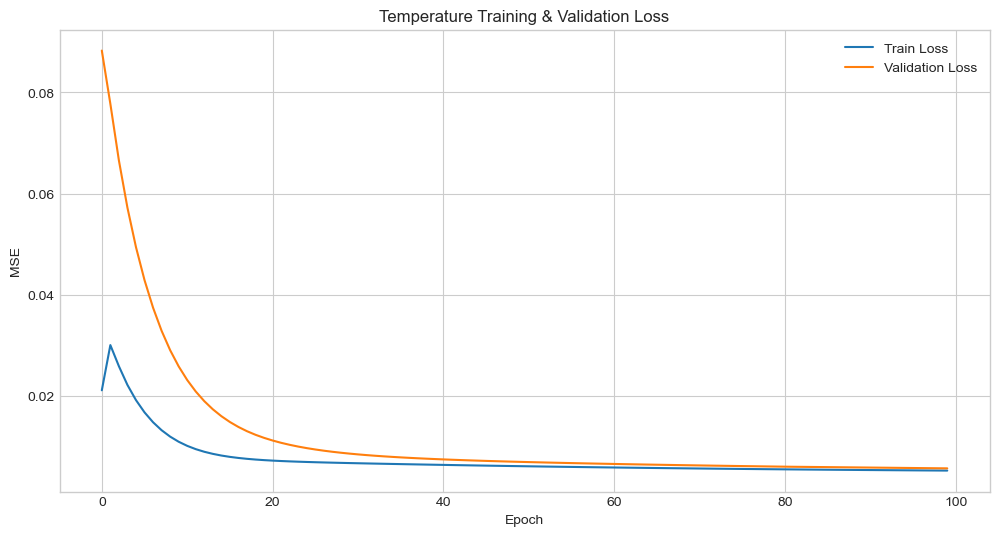

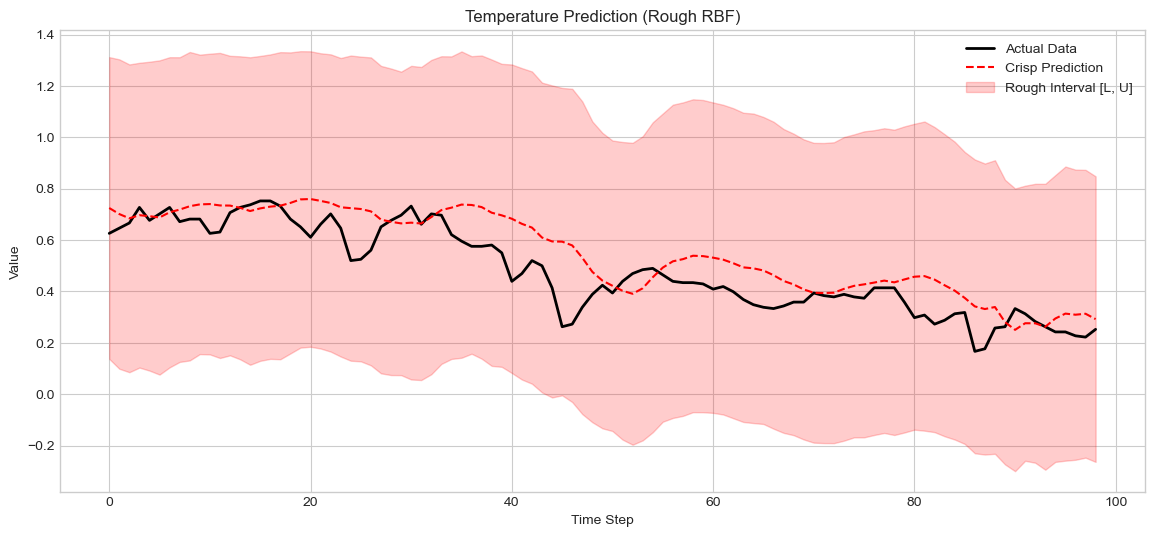

In [16]:
# --- Temperature Training ---

# 1. Build Model
# Temperature data is simpler, 10 kernels should suffice
model_temp = build_rough_rbf_network(input_dim=5, num_kernels=10)

# 2. Compile
# Slightly lower learning rate for stability on smaller dataset
optimizer = SGD(lr=0.01, lr_centers=0.005, lr_sigmas=0.005)
loss_fn = MSELoss()

model_temp.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
print("Training on Temperature Dataset...")
history_t = model_temp.fit(X_train_t, y_train_t, 
                           validation_data=(X_test_t, y_test_t),
                           epochs=100, verbose=True, log_freq=10)

# 4. Plot Loss
plt.figure()
plt.plot(history_t['loss'], label='Train Loss')
plt.plot(history_t['val_loss'], label='Validation Loss')
plt.title("Temperature Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 5. Visualize Predictions
plot_rough_predictions(model_temp, X_test_t, y_test_t, 
                       title="Temperature Prediction (Rough RBF)")

# 6

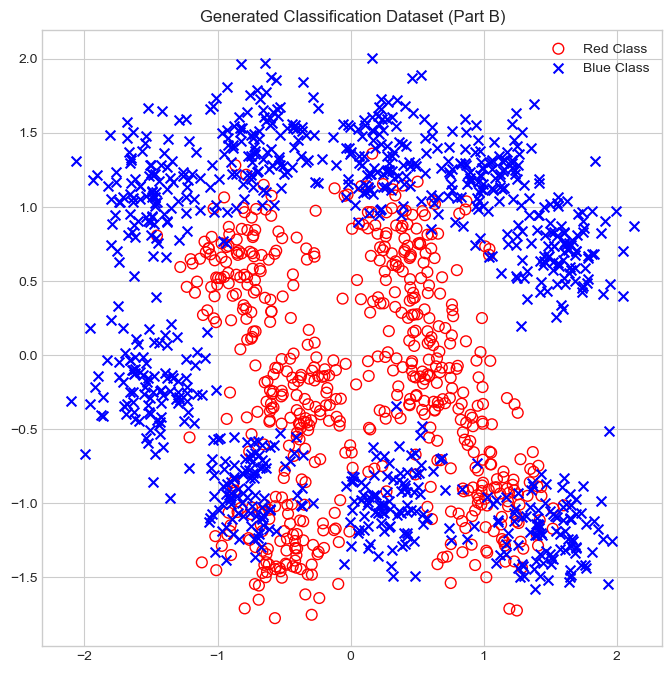

In [17]:
# 1. Generate Data
X_cls, y_cls = DataHandler.generate_classification_dataset()

# 2. Visualize Raw Data
plt.figure(figsize=(8, 8))
# Plot Red Class (Label 0)
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], 
            facecolors='none', edgecolors='r', s=60, label='Red Class')
# Plot Blue Class (Label 1)
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], 
            marker='x', c='b', s=50, label='Blue Class')

plt.title("Generated Classification Dataset (Part B)")
plt.legend()
plt.grid(True)
plt.show()

# 7

Running Unsupervised Competitive Learning...
Starting Competitive Learning for 30 epochs...
Epoch 10/30, Total Shift: 37.6247
Epoch 20/30, Total Shift: 34.1226
Epoch 30/30, Total Shift: 30.7084


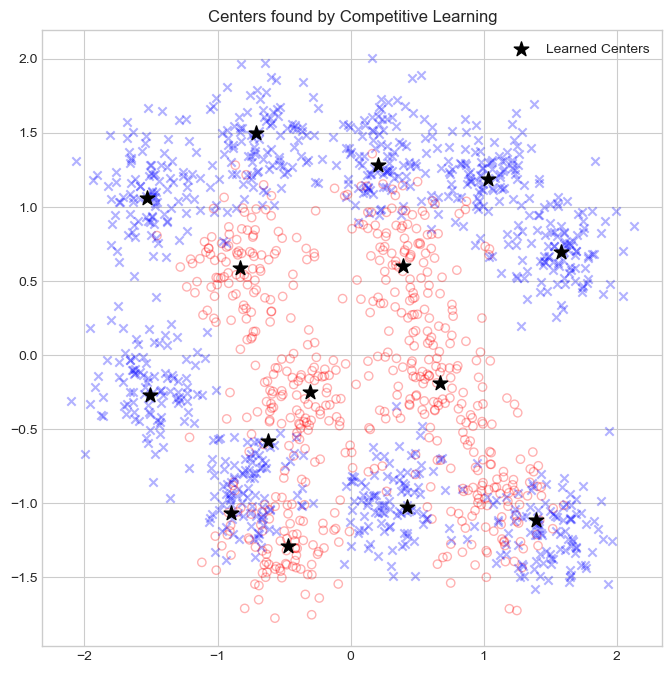

In [18]:
# We estimate number of centers based on the generation logic (6 red + 9 blue = 15)
NUM_CENTERS = 15
INPUT_DIM = 2

# 1. Initialize Competitive Learning
comp_learning = CompetitiveLearning(num_centers=NUM_CENTERS, input_dim=INPUT_DIM, learning_rate=0.1)

# 2. Fit to find centers (Unsupervised)
print("Running Unsupervised Competitive Learning...")
found_centers = comp_learning.fit(X_cls, epochs=30)

# 3. Visualize Centers
plt.figure(figsize=(8, 8))
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], edgecolors='r', facecolors='none', alpha=0.3)
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], marker='x', c='b', alpha=0.3)
plt.scatter(found_centers[:, 0], found_centers[:, 1], c='k', s=120, marker='*', label='Learned Centers')
plt.title("Centers found by Competitive Learning")
plt.legend()
plt.show()

# 8

Training Classification Network (Output Weights Only)...
Starting Training | Mode: SGD | Epochs: 100 | Samples: 1200
Validation enabled | Val Samples: 300


Epoch 1/100: 100%|██████████| 1200/1200 [00:01<00:00, 818.34sample/s, train_loss=0.41919]


Epoch 1 finished. Train Loss: 0.166710 | Val Loss: 0.172484


Epoch 10/100: 100%|██████████| 1200/1200 [00:01<00:00, 901.03sample/s, train_loss=0.11906]


Epoch 10 finished. Train Loss: 0.109903 | Val Loss: 0.114202


Epoch 20/100: 100%|██████████| 1200/1200 [00:01<00:00, 914.09sample/s, train_loss=0.05377]


Epoch 20 finished. Train Loss: 0.093994 | Val Loss: 0.097152


Epoch 30/100: 100%|██████████| 1200/1200 [00:01<00:00, 875.10sample/s, train_loss=0.02910]


Epoch 30 finished. Train Loss: 0.085820 | Val Loss: 0.088748


Epoch 40/100: 100%|██████████| 1200/1200 [00:01<00:00, 837.65sample/s, train_loss=0.01693]


Epoch 40 finished. Train Loss: 0.081282 | Val Loss: 0.084019


Epoch 50/100: 100%|██████████| 1200/1200 [00:01<00:00, 868.92sample/s, train_loss=0.01043]


Epoch 50 finished. Train Loss: 0.078683 | Val Loss: 0.081185


Epoch 60/100: 100%|██████████| 1200/1200 [00:01<00:00, 902.30sample/s, train_loss=0.00683]


Epoch 60 finished. Train Loss: 0.077146 | Val Loss: 0.079420


Epoch 70/100: 100%|██████████| 1200/1200 [00:01<00:00, 839.04sample/s, train_loss=0.00481]


Epoch 70 finished. Train Loss: 0.076193 | Val Loss: 0.078264


Epoch 80/100: 100%|██████████| 1200/1200 [00:01<00:00, 921.88sample/s, train_loss=0.00363]


Epoch 80 finished. Train Loss: 0.075565 | Val Loss: 0.077457


Epoch 90/100: 100%|██████████| 1200/1200 [00:01<00:00, 893.81sample/s, train_loss=0.00294]


Epoch 90 finished. Train Loss: 0.075122 | Val Loss: 0.076859


Epoch 100/100: 100%|██████████| 1200/1200 [00:01<00:00, 934.15sample/s, train_loss=0.00254]


Epoch 100 finished. Train Loss: 0.074784 | Val Loss: 0.076393
Training Complete. Time: 31.42s


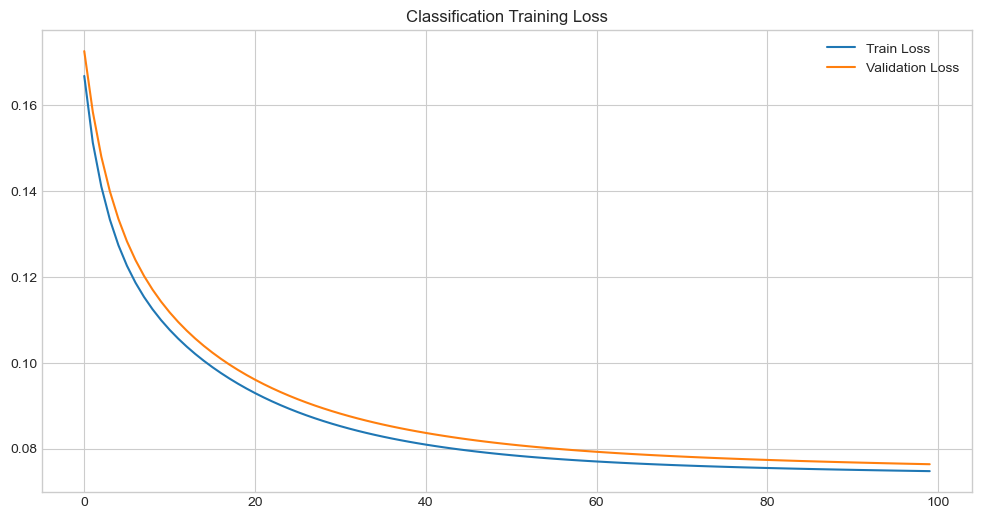

In [24]:
# 1. Build Model manually to access layers
model_cls = Sequential()
rbf_layer = RoughRBFLayer(input_dim=INPUT_DIM, num_kernels=NUM_CENTERS)
dense_layer = RoughDenseLayer(input_dim=NUM_CENTERS, output_dim=1)

model_cls.add(rbf_layer)
model_cls.add(dense_layer)

# 2. Inject Learned Centers
# This sets c_L = centers and c_U = centers + margin
rbf_layer.init_centers(found_centers)

# 3. Compile with Frozen RBF parameters
# Setting lr_centers=0 and lr_sigmas=0 ensures Part B requirements:
# "Fixed standard deviation and fixed centers, only output weights are Rough trained"
optimizer = SGD(lr=0.00075, lr_centers=0.0, lr_sigmas=0.0)
loss_fn = MSELoss() 

model_cls.compile(loss=loss_fn, optimizer=optimizer)

# 4. Train (Supervised Phase)
# Shuffling is important for classification
X_train_c, X_test_c, y_train_c, y_test_c = DataHandler.train_test_split(X_cls, y_cls, train_ratio=0.8, shuffle=True)

print("Training Classification Network (Output Weights Only)...")
history_c = model_cls.fit(X_train_c, y_train_c, 
                          validation_data=(X_test_c, y_test_c),
                          epochs=100, verbose=True, log_freq=10)

# Plot Loss
plt.figure()
plt.plot(history_c['loss'], label='Train Loss')
plt.plot(history_c['val_loss'], label='Validation Loss')
plt.title("Classification Training Loss")
plt.legend()
plt.show()

# 9

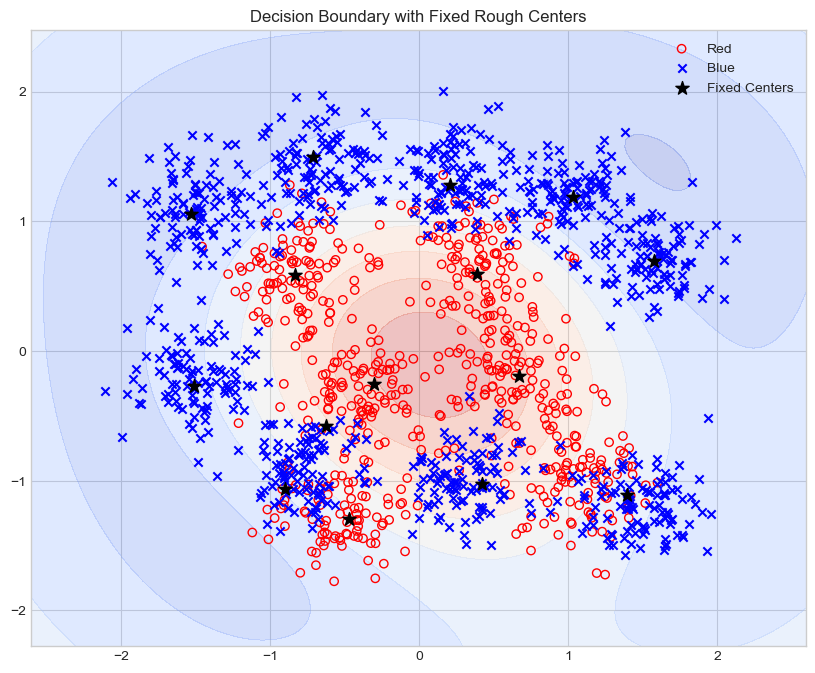

In [26]:
# 1. Create Meshgrid
x_min, x_max = X_cls[:, 0].min() - 0.5, X_cls[:, 0].max() + 0.5
y_min, y_max = X_cls[:, 1].min() - 0.5, X_cls[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# 2. Predict on Grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
preds = model_cls.predict(grid_points)
preds = preds.reshape(xx.shape)

# 3. Plot Contour
plt.figure(figsize=(10, 8))
# Plot decision regions (output > 0.5 is Blue, < 0.5 is Red)
plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm.reversed())

# Plot Original Data
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], edgecolors='r', facecolors='none', label='Red')
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], marker='x', c='b', label='Blue')

# Plot Fixed Centers
plt.scatter(found_centers[:, 0], found_centers[:, 1], c='k', s=100, marker='*', label='Fixed Centers')

plt.title("Decision Boundary with Fixed Rough Centers")
plt.legend()
plt.show()